In [1]:
import cv2
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import tarfile
import seaborn as sns
from sklearn.model_selection import train_test_split

GEN_DATA=True

In [ ]:
if not GEN_DATA:
    print("GEN_DATA disabled")

else:

    images_abnormal = []
    images_normal = []


    for filename in os.listdir('Dataset/abnormal'):
        if filename.endswith('.jpg') and filename != 'abnormal h_004.jpg':
            image = cv2.imread(os.path.join('Dataset/abnormal', filename))
            #image = image[120:-50, :]
            #image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images_abnormal.append(image)
            
    for filename in os.listdir('Dataset/normal'):
        if filename.endswith('.jpg'):
            image = cv2.imread(os.path.join('Dataset/normal', filename))
            #image = image[120:-50, :]
            #image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images_normal.append(image)
            
    for i in range(len(images_abnormal)):
        cv2.imwrite(f'Dataset/abnormal/resized/abnormal_image_resized_{i+1}.jpg', images_abnormal[i])

    for i in range(len(images_normal)):
        cv2.imwrite(f'Dataset/normal/resized/normal_image_resized_{i+1}.jpg', images_normal[i])

In [ ]:
directories = [
    'Dataset/abnormal/resized',
    'Dataset/normal/resized',
    'Dataset/normal',
    'Dataset/abnormal'
]

for directory in directories:
    
    image_set_name = directory.split('/')[1]
    
    if os.path.exists('{}/{}.npy'.format(directory, image_set_name)):
        
        print('{}.npy already exists'.format(image_set_name))
        
    else:
    
        print('Creating {}.npy'.format(image_set_name))

        image_data = []

        for filename in os.listdir(directory):

            if filename.endswith('.jpg'):

                img_path = os.path.join(directory, filename)
                img = Image.open(img_path)

                img_array = np.array(img)

                image_data.append(img_array)


        image_data = np.array(image_data)

        np.save('{}/{}'.format(directory, image_set_name), image_data)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

class ConvNet(nn.Module):
    
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 253 * 253, 120)  # Updated size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def np_to_torchLoader(images_np, labels_np, batchSize):
    images_torch = np.array(images_np)
    labels_torch = np.array(labels_np)

    images_tensor = torch.Tensor(images_torch).unsqueeze(1)
    labels_tensor = torch.Tensor(labels_torch).type(torch.LongTensor)

    DataSet = TensorDataset(images_tensor, labels_tensor)
    Loader = DataLoader(DataSet, batch_size=batchSize)
    return Loader

def trainCNN(images_np, labels_np, test_np, test_labels_np, numImages=10000000, 
             num_classes=2, epochs=20):
    
    images_np = images_np[0:numImages]
    labels_np = labels_np[0:numImages]
    
    convNet = ConvNet(num_classes)
    
    percentCorrectPerEpochTrain = []
    percentCorrectPerEpochTest = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)
    loss = 1

    for epoch in range(epochs):
        loader = np_to_torchLoader(images_np, labels_np, 256)
        running_loss = 0.0
        for i, data in enumerate(loader):

            inputs, labels = data
            
            optimizer.zero_grad()
   
            outputs = convNet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      
            if i % 255 == 0:  
                print(f'Epoch {epoch+1} loss: {running_loss / 256 :.7f}')
                loss = running_loss / 256
 
            running_loss = 0.0
        
        loader = np_to_torchLoader(images_np, labels_np, 1)
        train_accuracy, _, _ = testCNN(convNet, loader, num_classes)
        loader = np_to_torchLoader(test_np, test_labels_np, 1)
        test_accuracy, _, _ = testCNN(convNet, loader, num_classes)
        percentCorrectPerEpochTrain.append(train_accuracy)
        percentCorrectPerEpochTest.append(test_accuracy)
        
    print('Finished Training')

    return convNet, percentCorrectPerEpochTrain, percentCorrectPerEpochTest

def testCNN(convNet, loader, num_classes):
    wrongly_classified = {}
    confusion_mat = np.zeros((num_classes, num_classes))
    numCorrect = 0
    dataiter = iter(loader)
    for image, label in dataiter:
        yhat = convNet(image)
        _, predicted = torch.max(yhat, 1)
        if predicted == label: 
            numCorrect += 1
        elif predicted[0].item() in wrongly_classified:
            wrongly_classified[predicted[0].item()].append((image, label[0].item()))
        else:
            wrongly_classified[predicted[0].item()] = [(image, label[0].item())]
        
        confusion_mat[label, predicted] += 1
            
    return numCorrect/len(dataiter), wrongly_classified, confusion_mat

def plot_accuracy_per_epoch(epochs, train, test, title):
    plt.figure(figsize=(6, 6))
    plt.plot(range(1, epochs+1), train, label = "Train Accuracy Over Epochs")
    plt.plot(range(1, epochs+1), test, label = "Validation Accuracy Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

# Define the CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=6, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=6, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=6, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = None  # Dynamically initialized
        #self.fc2 = nn.Linear(120, 2)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        #if self.fc1 is None:
        #    self.fc1 = nn.Linear(x.size(1), 120).to(x.device)
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 120).to(x.device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x  # Raw logits; apply sigmoid during loss calculation if needed

# Train CNN
def trainCNN(images_np, labels_np, test_np, test_labels_np, numImages=10000000, 
             epochs=20, batch_size=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images_np, labels_np = images_np[:numImages], labels_np[:numImages]

    # Convert data to tensors
    train_loader = np_to_torchLoader(images_np, labels_np, batch_size)
    test_loader = np_to_torchLoader(test_np, test_labels_np, batch_size)

    model = ConvNet().to(device)

    # Use BCEWithLogitsLoss for raw logits
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    percentCorrectPerEpochTrain = []
    percentCorrectPerEpochTest = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()  # Convert labels to float for BCE

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Flatten outputs for BCEWithLogitsLoss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Evaluate accuracy after each epoch
        train_acc = compute_accuracy(model, train_loader, device)
        test_acc = compute_accuracy(model, test_loader, device)
        print(f"Epoch [{epoch+1}] Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
        
        percentCorrectPerEpochTrain.append(train_acc)
        percentCorrectPerEpochTest.append(test_acc)
        

    return model, percentCorrectPerEpochTrain, percentCorrectPerEpochTest

# Compute Accuracy
def compute_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = torch.sigmoid(model(inputs).squeeze())  # Apply sigmoid to get probabilities
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Convert Numpy Arrays to DataLoader
def np_to_torchLoader(images_np, labels_np, batch_size):
    images_tensor = torch.Tensor(images_np).unsqueeze(1)
    labels_tensor = torch.Tensor(labels_np).type(torch.FloatTensor)
    dataset = TensorDataset(images_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# Test CNN
def testCNN(model, loader, device, num_classes):
    correct = 0
    total = 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # General accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Class-wise accuracy
            for i in range(len(labels)):
                label = labels[i]
                if predicted[i] == label:
                    class_correct[label] += 1
                class_total[label] += 1
    
    accuracy = 100 * correct / total
    return accuracy, class_correct, class_total

def plot_accuracy_per_epoch(epochs, train, test, title):
    plt.figure(figsize=(6, 6))
    plt.plot(range(1, epochs+1), train, label = "Train Accuracy Over Epochs")
    plt.plot(range(1, epochs+1), test, label = "Validation Accuracy Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

In [45]:
#abnormal = np.load('Dataset/abnormal/resized/abnormal.npy')
#normal = np.load('Dataset/normal/resized/normal.npy')

abnormal = np.load('Dataset/abnormal/resized/abnormal.npy')
normal = np.load('Dataset/normal/resized/normal.npy')

abnormal_labels = np.zeros(len(normal)) 
normal_labels = np.ones(len(abnormal)) 


images = np.concatenate([abnormal, normal], axis=0)
labels = np.concatenate([abnormal_labels, normal_labels], axis=0)


images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
convNet, percentCorrectPerEpochTrain, percentCorrectPerEpochTest = trainCNN(images_train, 
                                                                            labels_train, 
                                                                            images_test,
                                                                            labels_test, 
                                                                            batch_size=50)

Epoch [1/20], Batch [1/4], Loss: 0.8249
Epoch [1/20], Batch [2/4], Loss: 0.7115


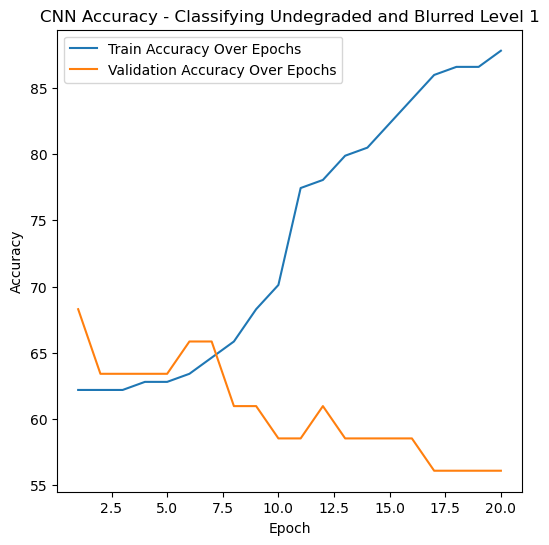

In [14]:
plot_accuracy_per_epoch(20, percentCorrectPerEpochTrain, percentCorrectPerEpochTest, 
                        "CNN Accuracy - Classifying Undegraded and Blurred Level 1")